# Vulnerability database

In [1]:
# HIDE CODE
# Import necessary libraries
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
import matplotlib.ticker as ticker
import matplotlib as mpl  
from matplotlib import rcParams
from scipy.stats import lognorm
import os
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import re
from pathlib import Path

In [2]:
# Detect project root (the folder containing the notebook)
project_root = Path().resolve()
print("Project root:", project_root)

# Define data and results folders
data_path = project_root / "data"
results_path = project_root / "results"

# Create folders if they do not exist
data_path.mkdir(exist_ok=True)
results_path.mkdir(exist_ok=True)

print("Data folder:", data_path)
print("Results folder:", results_path)


# Define paths to the MIRACA vulnerability tables

file_D1 = data_path / "Table_D1_Summary_CI_Vulnerability_Data_V2.0.0_AUTH.xlsx"
file_D2 = data_path / "Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V2.0.0_AUTH.xlsx"
file_D3 = data_path / "Table_D3_Costs_V2.0.0_AUTH.xlsx"

Project root: C:\Users\Paraskevi Tsoumani\miraca_vulnerability_database
Data folder: C:\Users\Paraskevi Tsoumani\miraca_vulnerability_database\data
Results folder: C:\Users\Paraskevi Tsoumani\miraca_vulnerability_database\results


Identify number and type of vulnerability curves available per sector and hazard

This dictionary defines the MIRACA colour palette, containing all hex colour codes used for consistent styling in plots and visual outputs.

In [3]:
# MIRACA color palette
colors = {
    "primary_blue_500": "#4069F6",
    "red": "#ED5861",
    "grey_600": "#7B7F8F",
    "yellow": "#FBC40B",
    "blue_100": "#E0E7FE",
    "green_500": "#64F4C0",
    "green_500": "#64F4C0",
    "white": "#FFFFFF",
    "black": "#1F1E37",
}

This dictionary maps the hazard codes found in the MIRACA vulnerability sheets to their full descriptive hazard names, ensuring consistent interpretation across sectors and analyses.


In [4]:
# Workbook handler
xls = pd.ExcelFile(file_D1)

# Hazard mapping
hazard_mapping = {
    'E': 'Earthquakes',
    'F': 'Floods',
    'L': 'Landslides',
    'W': 'Windstorms',  # Updated for Windstorms
    'WF': 'Wildfires',  # Updated for Wildfires
    'E+L': 'Earthquakes + Landslides',
    'E+F': 'Earthquakes + Floods',
    'E+Liq': 'Earthquakes + Liquefaction',
    'E+W': 'Earthquakes + Windstorms',  # Corrected mapping
    'Multi-Hazard': 'Multi-Hazard'
}

Total number of curves per asset 

In [5]:
asset_counts = {}

for sheet_name in xls.sheet_names:
    df_sheet = pd.read_excel(file_D1, sheet_name=sheet_name, header=1)

    # Identify ID column → only asset sheets have curves
    id_cols = [col for col in df_sheet.columns if 'id number' in col.lower()]
    if not id_cols:
        continue

    id_col = id_cols[0]
    asset_counts[sheet_name] = df_sheet[id_col].nunique()

# Convert to DataFrame
asset_counts_df = pd.DataFrame.from_dict(asset_counts, orient='index', columns=['Total Curves'])

print("Total Number of Curves per asset:")
display(asset_counts_df)

# Save total curves per asset
asset_counts_df.to_csv(results_path / "Total_curves_per_asset.csv", index=True)

Total Number of Curves per asset:


,Total Curves
Energy,446
Transportation,398
Telecommunication,27
Water,147
Waste,98
Education & Health,213


Total number of curves per hazard

In [6]:
hazard_counts = {}

for sheet_name in xls.sheet_names:
    df_sheet = pd.read_excel(file_D1, sheet_name=sheet_name, header=1)

    # Detect ID column → skip non-asset sheets
    id_cols = [col for col in df_sheet.columns if 'id number' in col.lower()]
    if not id_cols:
        continue
    id_col = id_cols[0]

    # Detect hazard column
    hazard_cols = [col for col in df_sheet.columns if 'hazard' in col.lower()]
    if not hazard_cols:
        continue
    hazard_col = hazard_cols[0]

    # Clean hazard labels
    df_sheet[hazard_col] = df_sheet[hazard_col].astype(str).str.strip().str.upper()

    # Remove invalid hazard labels
    df_sheet = df_sheet[
        df_sheet[hazard_col].notna() &
        (df_sheet[hazard_col] != "") &
        (~df_sheet[hazard_col].isin(["NAN", "NONE", "NA", "N/A"]))
    ]

    # Group combined hazards as Multi-hazard
    df_sheet[hazard_col] = df_sheet[hazard_col].apply(
        lambda x: "Multi-hazard" if "+" in x else x
    )

    # Count curves per hazard
    grouped = df_sheet.groupby(hazard_col)[id_col].nunique()

    # Add to global totals, converting codes to full names
    for hazard, count in grouped.items():
        full_name = hazard_mapping.get(hazard, hazard)
        hazard_counts[full_name] = hazard_counts.get(full_name, 0) + count

# Convert to DataFrame
hazard_counts_df = pd.DataFrame.from_dict(
    hazard_counts, orient='index', columns=['Total Curves']
)

print("\nTotal Number of Curves per Hazard:")
display(hazard_counts_df)

# Save total curves per hazard
hazard_counts_df.to_csv(results_path / "Total_curves_per_hazard.csv", index=True)


Total Number of Curves per Hazard:


,Total Curves
Earthquakes,762
Floods,111
Landslides,147
Multi-hazard,47
Windstorms,254
Wildfires,8


Detailed summary per asset

In [7]:
# Dictionary to store summary per asset
asset_summary = {}

for sheet_name in xls.sheet_names:
    
    # Read sheet (header row 1)
    df_sheet = pd.read_excel(file_D1, sheet_name=sheet_name, header=1)

    # ---- Detect ID column (only sheets with assets have ID numbers) ----
    id_cols = [col for col in df_sheet.columns if 'id number' in col.lower()]
    if not id_cols:
        continue  # skip non-asset sheets

    id_col = id_cols[0]

    # ---- Count total number of curves ----
    total_curves = df_sheet[id_col].nunique()

    # ---- Detect curve type column ----
    curve_type_cols = [col for col in df_sheet.columns if 'fragility' in col.lower()]
    if curve_type_cols:
        curve_type_col = curve_type_cols[0]
        curve_type_counts = df_sheet[curve_type_col].value_counts(dropna=True)
        curve_types = ", ".join(curve_type_counts.index.astype(str))
        curve_type_counts_str = ", ".join([f"{k}: {v}" for k, v in curve_type_counts.items()])
    else:
        curve_type_col = None
        curve_types = ""
        curve_type_counts_str = ""

    # ---- Detect hazard type column ----
    hazard_cols = [col for col in df_sheet.columns if 'hazard' in col.lower()]
    if hazard_cols:
        hazard_col = hazard_cols[0]
        hazard_counts = df_sheet[hazard_col].value_counts(dropna=True)
        hazard_types = ", ".join(hazard_counts.index.astype(str))
        hazard_counts_str = ", ".join([f"{k}: {v}" for k, v in hazard_counts.items()])
    else:
        hazard_col = None
        hazard_types = ""
        hazard_counts_str = ""

    # ---- Store summary ----
    asset_summary[sheet_name] = {
        "Total Curves": total_curves,
        "Curve Types": curve_types,
        "Count per Curve Type": curve_type_counts_str,
        "Hazard Types": hazard_types,
        "Count per Hazard Type": hazard_counts_str,
    }


# Convert dictionary to DataFrame
summary_df = pd.DataFrame.from_dict(asset_summary, orient='index')


# === Curve Type Summary Table ===

curve_type_table = summary_df[[
    "Total Curves",
    "Curve Types",
    "Count per Curve Type"
]]

print("Curve Type Summary:")
display(curve_type_table)

# Save file
curve_type_table.to_csv(results_path / "Curve_type_summary.csv")

# === Hazard Type Summary Table ===

hazard_type_table = summary_df[[
    "Total Curves",
    "Hazard Types",
    "Count per Hazard Type"
]]

print("Detailed Hazard Summary:")
display(hazard_type_table)

# Save file
hazard_type_table.to_csv(results_path / "Hazard_type_summary.csv")

Curve Type Summary:


,Total Curves,Curve Types,Count per Curve Type
Energy,446,"F, F + V, V","F: 348, F + V: 72, V: 26"
Transportation,398,"F, V, F + V, V (repair rate)","F: 306, V: 69, F + V: 22, V (repair rate): 1"
Telecommunication,27,"F, V, F + V","F: 23, V: 2, F + V: 2"
Water,147,"V (repair rate), F, V, F + V","V (repair rate): 57, F: 45, V: 25, F + V: 20"
Waste,98,"V (faults/km), V (repair rate), V, F + V, F","V (faults/km): 36, V (repair rate): 31, V: 14,..."
Education & Health,213,"F, F + V, V, F + V (3D)","F: 119, F + V: 65, V: 25, F + V (3D): 5"


Detailed Hazard Summary:


,Total Curves,Hazard Types,Count per Hazard Type
Energy,446,"E, W, F, E+W, L","E: 209, W: 203, F: 16, E+W: 12, L: 6"
Transportation,398,"E, L, F, E+F, W","E: 283, L: 65, F: 32, E+F: 16, W: 2"
Telecommunication,27,"W, E, F, L","W: 21, E: 3, F: 2, L: 1"
Water,147,"E, L, F, W","E: 81, L: 39, F: 25, W: 2"
Waste,98,"E, L, F, W","E: 56, L: 26, F: 14, W: 2"
Education & Health,213,"E, W, F, E+F, L, WF, E+Liq, E , E+L","E: 131, W: 24, F: 22, E+F: 14, L: 11, WF: 8, E..."


Statistics plots

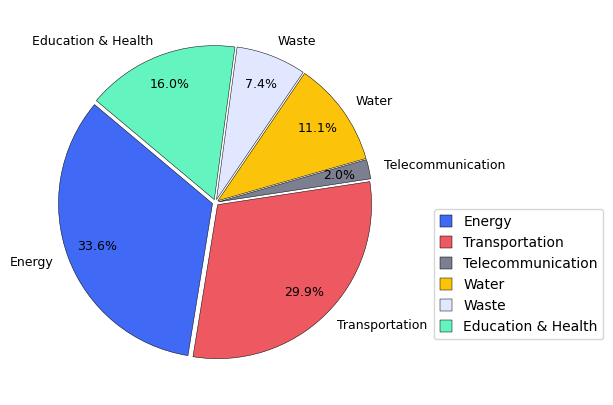

In [8]:
# Get MIRACA colors in the exact order defined in the dictionary
miraca_color_list = list(colors.values())

# Number of assets
n_assets = len(asset_counts_df)

# Take only the first n colors
color_list = miraca_color_list[:n_assets]

# Extract data
asset_counts_series = asset_counts_df["Total Curves"]


explode_value = 0.02
explode = [explode_value] * len(hazard_counts_df["Total Curves"])

fig, ax = plt.subplots(figsize=(6, 5))

wedges, texts, autotexts = ax.pie(
    asset_counts_series,
    labels=asset_counts_series.index,
    autopct='%1.1f%%',
    colors=color_list,
    explode=explode,          
    startangle=140,
    pctdistance=0.8,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.35}
)

# Text styling
for t in texts:
    t.set_fontsize(9)
for a in autotexts:
    a.set_fontsize(9)
    a.set_color("black")


# Legend
ax.legend(
    loc='best',
    bbox_to_anchor=(1.05, 0.5),
    markerscale=0.8,
    handlelength=0.9,
    handleheight=0.9,
    fontsize=10
)

# Save figure
plt.savefig(results_path / "Asset_Distribution.png",
            dpi=400, bbox_inches='tight')

plt.show()


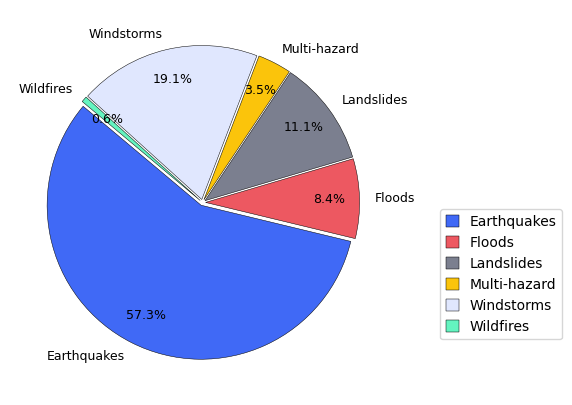

In [9]:
# === PIE CHART: Hazard Distribution using MIRACA Colors (explode all) ===

# Extract hazard data from your earlier summary
hazard_series = hazard_counts_df["Total Curves"]

# MIRACA colors in the exact order defined in the dictionary
miraca_color_list = list(colors.values())

# Match number of colors to number of hazard categories
color_list = miraca_color_list[:len(hazard_series)]

# Explode all slices equally
explode_value = 0.02
explode = [explode_value] * len(hazard_series)

fig, ax = plt.subplots(figsize=(6, 5))

wedges, texts, autotexts = ax.pie(
    hazard_series,
    labels=hazard_series.index,      # already has full names e.g. "Earthquakes"
    autopct='%1.1f%%',
    colors=color_list,
    explode=explode,
    startangle=140,
    pctdistance=0.8,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.35}
)

# Text styling
for t in texts:
    t.set_fontsize(9)
for a in autotexts:
    a.set_fontsize(9)
    a.set_color("black")


# Legend (same style as asset pie)
ax.legend(
    wedges,
    hazard_series.index,
    bbox_to_anchor=(1.1, 0.5), 
    markerscale=0.7,  # This is for scaling the size of the marker (bars)
    handlelength=0.9,  # Adjust the length of the legend marker (bar)
    handleheight=0.9,  # Adjust the height of the legend marker (bar)
    fontsize=10,
)


# Save figure
plt.savefig(results_path / "Hazard_Distribution.png",
            dpi=400, bbox_inches='tight')

plt.show()


Filter to choose the appropriate ID Number (selection of specific curves)

In [23]:
def filter_curves(network, hazard_type, intensity_metric, cost_feature, geographical_application):
    """
    Filters the D1 table based on user criteria and returns:
      - styled_df → formatted for display()
      - filtered_df → raw DataFrame (useful for extracting ID numbers)
    """

    # Load sheet
    df1 = pd.read_excel(file_D1, sheet_name=network, header=1)

    # ----- Build filter condition -----
    condition = (
        (df1['Hazard type'] == hazard_type) &
        (df1['Intensity metric'] == intensity_metric) &
        (df1['Cost feature'] == cost_feature) &
        (df1['Geographical application'] == geographical_application)
    )

    # ----- Select the columns EXACTLY as they appear -----
    filtered_df = df1.loc[
        condition,
        [
            'ID number',
            'Infrastructure description',
            'Additional characteristics\xa0',
            'Characteristics of curve',
            'Fragility and/or vulnerability',
            'Damage states (in case of fragility)',
            'Reference'
        ]
    ]

    # Show full column width
    pd.set_option('display.max_colwidth', None)

    # ----- Styling -----
    styled_df = (
        filtered_df
            .style
            .set_properties(**{'text-align': 'left'})
            .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
    )

    return styled_df, filtered_df


In [24]:
# === Intensity mapping dictionary ===
intensity_mapping = {
    "Peak Ground Acceleration": ("PGA", "[g]"),
    "Peak Ground Velocity": ("PGV", "[cm/s]"),
    "Bedrock Peak Ground Velocity": ("PGV", "[cm/s]"),
    "Spectral acceleration": ("Sa", "[g]"),
    "Spectral acceleration (Sa (T1))": ("Sa", "[g]"),
    "Elastic spectral displacement": ("Sd", "[cm]"),
    "3s gust wind speed at 10 m height": ("V10m", "[m/s]"),
    "3-s gust wind speed ": ("V10m", "[m/s]"),
    "Wind speed": ("V10m", "[m/s]"),
    "Permanent ground displacement": ("PGD", "[cm]"),
    "Peak Ground Displacement": ("PGD", "[cm]"),
    "Inundation": ("Depth", "[m]"),
    "fire intensity measure (in min) ": ("FIM", "[min]"),
    "Free field Peak Ground Velocity and Permanent Ground displacement ": ("PGV&PGD", "[cm/s]"),
    "Inundation+Duration": ("Depth&Duration", "[m]"),
    "Rainfall intensity and duration": ("Rainfall inten&durat", "[days]"),
    "3-sec peak gust wind speed at 10 m height": ("V10m", "[m/s]"),
}

In [25]:
def get_curve_metadata(ID_number, network):
    """
    Extracts curve metadata from D1 for a specific ID_number and network.

    Returns:
        hazard_type
        intensity_metric
        fragility_vulnerability
        damage_states_list
        num_damage_states
        reference
    """

    column_name = "ID number"

    # Load D1 sheet
    df1 = pd.read_excel(file_D1, sheet_name=network, header=1)

    # Filter for the chosen ID
    filtered_rows = df1[df1[column_name] == ID_number]

    if filtered_rows.empty:
        print(f"⚠ ID {ID_number} not found in sheet {network}")
        return None

    row = filtered_rows.iloc[0]

    # ---- Extract main metadata ----
    hazard_type = row.get("Hazard type", None)
    intensity_metric = row.get("Intensity metric", None)
    fragility_vulnerability = row.get("Fragility and/or vulnerability", None)
    damage_states_raw = row.get("Damage states (in case of fragility)", None)
    reference = row.get("Reference", None)

    print("\nCurve info :")
    print("Hazard Type:", hazard_type)
    print("Intensity Metric:", intensity_metric)
    print("Fragility/Vulnerability Type:", fragility_vulnerability)
    print("Reference:", reference)

    IM_code, IM_units = intensity_mapping.get(intensity_metric, ("Unknown", "Unknown"))

    print("\nIntensity Measure Code:", IM_code)
    print("Units:", IM_units)

    # ---- Extract damage states ----
    damage_states_list = []
    num_damage_states = 0

    if damage_states_raw and not pd.isna(damage_states_raw):

        # Check two formats
        if "-" in str(damage_states_raw):
            # Format: e.g. 5 - EMS-98 - 'DS1:...', 'DS2:...'
            states_part = str(damage_states_raw).split("-")[-1]
            damage_states_list = re.findall(r"'(.*?)'", states_part)

        else:
            # Format: 'Slight', 'Moderate', ...
            damage_states_list = re.findall(r"'(.*?)'", str(damage_states_raw))

        num_damage_states = len(damage_states_list)

        print("\nExtracted Damage States:", damage_states_list)
        print("Number of Damage States:", num_damage_states)

    else:
        print("\n⚠ No damage states found.")

    # Return everything cleanly
    return (
        hazard_type,
        intensity_metric,
        fragility_vulnerability,
        damage_states_list,
        num_damage_states,
        reference,
        IM_code,
        IM_units
    )


Plot Fragility or/and Vulnerability curves based on the ID number selected

In [26]:
# Adjust your font sizes
mpl.rc('font',family='Calibri')
font = {'family': 'Calibri', 'weight': 'bold'}
rcParams['mathtext.default'] = 'regular'
rcParams['mathtext.rm'] = font['family']

RGB=255
color1=(64/RGB,64/RGB,160/RGB)
color2=(22/RGB,219/RGB,101/RGB)
color3=(244/RGB,140/RGB,6/RGB)
color4=(208/RGB,0/RGB,0/RGB)
color5=(106/RGB,4/RGB,15/RGB)

In [27]:
# Define a function for the formatter
def format_func(value, tick_number):
    if value == 0:
        return '0'  # return '0' when the value is 0
    else:
        return f'{value:.1f}'

In [28]:
def set_frag_plot_style(fig, ax, ID_number, intensity_metric, units):
    fig.patch.set_facecolor('#f2f2f2')
    ax.set_facecolor('#ffffff')
    ax.set_xlabel(intensity_metric + " " + units,
                  fontsize=12, labelpad=6, c='black', **font)
    ax.set_ylabel("Probability of Exceedance",
                  fontsize=12, labelpad=12, c='black', **font)
    ax.set_title(ID_number, fontsize=13, c='black',
                 **font, y=1.02, fontweight="bold")
    ax.legend(
        loc='best', fontsize=10, fancybox=True, frameon=True, shadow=False,
        borderpad=0.5, edgecolor="black", framealpha=0.7, labelcolor="black"
    )
    ax.set_ylim(0, 1)
    ax.grid(axis="both", c="black", alpha=0.2, linestyle=(0, (1, 3)))
    ax.tick_params(axis='x', which="major", direction="in",
                   size=4, color="black", pad=6, labelsize=10, labelcolor="black")
    ax.tick_params(axis='y', which="major", direction="in",
                   size=4, color="black", pad=6, labelsize=10, labelcolor="black")
    ax.tick_params(axis='both', which="minor", direction="in",
                   length=2, color="black", labelsize=9)
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1)
    ax.locator_params(axis="x", tight=True)
    ax.locator_params(axis="y", tight=True)

In [29]:
def set_vulne_plot_style(fig, ax, ID_number, intensity_metric, units):
    fig.patch.set_facecolor('#f2f2f2')
    ax.set_facecolor('#ffffff')
    ax.set_xlabel(intensity_metric + " " + units,
                  fontsize=12, labelpad=12, c='black', **font)
    ax.set_ylabel("Damage factor",
                  fontsize=12, labelpad=12, c='black', **font)
    ax.set_title(ID_number, fontsize=13, c='black',
                 **font, y=1.02, fontweight="bold")
    ax.set_ylim(0, 1)
    ax.grid(axis="both", c="black", alpha=0.2, linestyle=(0, (1, 3)))
    ax.tick_params(axis='x', which="major", direction="in",
                   size=4, color="black", pad=6, labelsize=10, labelcolor="black")
    ax.tick_params(axis='y', which="major", direction="in",
                   size=4, color="black", pad=6, labelsize=10, labelcolor="black")
    ax.tick_params(axis='both', which="minor", direction="in",
                   length=2, color="black", labelsize=9)
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1)
    ax.locator_params(axis="x", tight=True)
    ax.locator_params(axis="y", tight=True)

In [30]:
def set_3D_plot_style(fig, ax, title_text):
    """
    Clean & elegant 3D surface plot styling.
    Paper-ready aesthetics.
    """

    # === Background colors ===
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # === Title ===
    ax.set_title(
        title_text,
        fontsize=15,
        fontweight='bold',
        color='black',
        pad=20
    )

    # === Axis labels ===
    ax.set_xlabel("Depth (m)", fontsize=12, labelpad=12, color="black")
    ax.set_ylabel("Duration (hours)", fontsize=12, labelpad=12, color="black")
    ax.set_zlabel("Z-value", fontsize=12, labelpad=12, color="black")

    # === Tick styling ===
    ax.tick_params(
        axis='x', colors='black', labelsize=9, pad=2
    )
    ax.tick_params(
        axis='y', colors='black', labelsize=9, pad=2
    )
    ax.tick_params(
        axis='z', colors='black', labelsize=9, pad=2
    )

    # === White panes and clean grid ===
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis._axinfo["grid"]['color'] = "#DDDDDD"
    ax.yaxis._axinfo["grid"]['color'] = "#DDDDDD"
    ax.zaxis._axinfo["grid"]['color'] = "#DDDDDD"

    ax.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax.zaxis._axinfo["grid"]['linestyle'] = "--"

    ax.xaxis._axinfo["grid"]['linewidth'] = 0.4
    ax.yaxis._axinfo["grid"]['linewidth'] = 0.4
    ax.zaxis._axinfo["grid"]['linewidth'] = 0.4

    # === Give nice perspective ===
    ax.view_init(elev=25, azim=-55)

    # === Limits auto tighten ===
    ax.set_xlim(auto=True)
    ax.set_ylim(auto=True)
    ax.set_zlim(auto=True)

    # === Remove clutter borders ===
    ax.set_box_aspect([1.4, 1.0, 0.8])  # elegant aspect ratio


In [31]:
def extract_damage_states(damage_states):
    """
    Extracts damage states from the D1 text field.

    Handles:
    - Format with '-' e.g. "5 - EMS98 - 'DS1:...', 'DS2:...'"
    - Format without '-' e.g. "'Slight', 'Moderate', 'Extensive'"
    
    Returns:
        list of states (strings) or an empty list.
    """

    # Case 0: empty or None
    if damage_states is None or pd.isna(damage_states):
        return []

    text = str(damage_states)

    # Case 1: if there is "-" → EMS-like format
    if "-" in text:
        # take the last part after the last dash
        states_part = text.split("-")[-1]
        # extract anything inside single quotes
        states = re.findall(r"'(.*?)'", states_part)
        return states

    # Case 2: simple format "'Slight','Moderate',..."
    states = re.findall(r"'(.*?)'", text)
    if len(states) > 0:
        return states

    # Case 3: fallback – split by comma
    states = [s.strip() for s in text.split(",") if s.strip()]
    return states


In [32]:
def generate_3D_plot(sheet_name):
    """
    Reads a 3D D2 sheet automatically and produces the 3D surface plot.
    Works for every ID with 3D fragility-vulnerability data.
    """

    # Read sheet once with headers
    df_header = pd.read_excel(file_D2, sheet_name=sheet_name)
    # Read sheet once without headers (for numeric extraction)
    df = pd.read_excel(file_D2, sheet_name=sheet_name, header=None)
    df = df.apply(pd.to_numeric, errors='coerce')

    # -----------------------------
    # 1) DEPTH VALUES  (Row 4)
    # -----------------------------
    DEPTH_ROW = 4
    depth_values = df.iloc[DEPTH_ROW, 1:].dropna().values
    n_depths = len(depth_values)

    # -----------------------------
    # 2) DURATION VALUES (Column 0)
    # -----------------------------
    DURATION_START_ROW = 6
    duration_values = df.iloc[DURATION_START_ROW:, 0].dropna().values
    n_durations = len(duration_values)

    # -----------------------------
    # 3) Z-VALUE MATRIX
    #    shape = (n_durations, n_depths)
    # -----------------------------
    z_matrix = df.iloc[DURATION_START_ROW:, 1:n_depths+1].values

    # Safety check
    assert z_matrix.shape == (n_durations, n_depths), \
        f"❌ Shape mismatch: Z is {z_matrix.shape}, expected {(n_durations, n_depths)}"

    # -----------------------------
    # 4) Create meshgrid
    # -----------------------------
    X, Y = np.meshgrid(depth_values, duration_values)

    # -----------------------------
    # 5) Plotting
    # -----------------------------
    fig = plt.figure(figsize=(11,8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(
        X, Y, z_matrix,
        cmap='viridis',
        edgecolor='black',
        linewidth=0.15,
        antialiased=True,
        alpha=0.85
    )

    # Styling
    ax.set_xlabel("Depth (m)", fontsize=12, labelpad=12, color="black")
    ax.set_ylabel("Duration (hours)", fontsize=12, labelpad=12, color="black")
    ax.set_zlabel("Damage / Probability", fontsize=12, labelpad=10, color="black")
    ax.set_title(sheet_name, fontsize=14, fontweight="bold", color="black")

    # Axes style
    ax.tick_params(axis='both', labelsize=10, colors="black")
    ax.tick_params(axis='z', labelsize=10, colors="black")

    # Invert if needed
    ax.invert_yaxis()

    # Nice viewing angle
    ax.view_init(25, -55)
    plt.show()

    print("✔ 3D plot generated successfully.")


In [33]:
def generate_plots(ID_number):
    """
    Full plotting function WITHOUT requiring 'network'.
    Automatically detects which D1 sheet contains the given ID.
    Creates fragility, vulnerability or combined plots.
    """

    excel_name = file_D2  # D2 contains curves

    # ======================================================
    # 1) FIND THE CORRECT SHEET (network) FROM D1
    # ======================================================
    xls = pd.ExcelFile(file_D1)
    found_network = None
    row = None

    for sheet in xls.sheet_names:
        df_temp = pd.read_excel(file_D1, sheet_name=sheet, header=1)

        if "ID number" not in df_temp.columns:
            continue

        match = df_temp[df_temp["ID number"] == ID_number]
        if not match.empty:
            found_network = sheet
            row = match.iloc[0]
            break

    if found_network is None:
        print(f"❌ ID {ID_number} not found in ANY D1 sheet.")
        return

    # ======================================================
    # 2) EXTRACT METADATA FROM D1
    # ======================================================
    hazard_type = row["Hazard type"]
    intensity_metric = row["Intensity metric"]
    fragility_vulnerability = row["Fragility and/or vulnerability"]
    damage_states_text = row["Damage states (in case of fragility)"]

    # Extract damage states
    states = extract_damage_states(damage_states_text)
    num_states = len(states) if len(states) > 0 else 1

    # Intensity conversion
    Intensity_measure, units = intensity_mapping.get(intensity_metric, ("Unknown", ""))

    # ======================================================
    # 3) Filename generator
    # ======================================================
    def make_plot_name(id_number, mode, subtype):
        safe_id = str(id_number).replace("/", "_").replace(" ", "")
        return f"{safe_id}_{mode}_{subtype}.png"

    # ======================================================
    # 4) === PLOT GENERATION ===
    # ======================================================

    # ------------------------------------------------------
    #   CASE 1 — VULNERABILITY ONLY
    # ------------------------------------------------------
    if fragility_vulnerability == "V":

        sheet = f"{hazard_type}_Vuln_{Intensity_measure}"
        df = pd.read_excel(excel_name, sheet_name=sheet).iloc[4:]
        df = df[df[ID_number].notna()]
        column_name = df.columns[0]

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(df[column_name], df[ID_number], color="navy", linewidth=2.5)

        set_vulne_plot_style(fig, ax, ID_number, intensity_metric, units)
        ax.set_xlim(0, df[column_name].max())

        filename = make_plot_name(ID_number, "V", "VULN")
        plt.savefig(results_path / filename, dpi=300, bbox_inches="tight")
        plt.show()
        return

    # ------------------------------------------------------
    #   CASE 2 — FRAGILITY ONLY
    # ------------------------------------------------------
    if fragility_vulnerability == "F":

        sheet = f"{hazard_type}_Frag_{Intensity_measure}"

        # ========== Case 2A — CDF fragility ==========
        if "-C" in ID_number:

            df = pd.read_excel(excel_name, sheet_name=sheet)
            df_raw = df[df.notna().any(axis=1)]
            df_data = df_raw.iloc[4:]
            column_name = df_data.columns[0]

            df_header = pd.read_excel(excel_name, sheet_name=sheet, header=None)
            headers = df_header.iloc[4].tolist()

            medians = df_raw.iloc[4]
            betas = df_raw.iloc[6]

            id_index = df_raw.columns.get_loc(ID_number)

            fig, ax = plt.subplots(figsize=(6, 4))
            colors = [color1, color2, color3, color4, color5]

            for i in range(num_states):
                col_idx = id_index + i
                if col_idx >= len(df_raw.columns):
                    continue

                col_name = df_raw.columns[col_idx]
                header = headers[col_idx]

                med = medians[col_name]
                beta = betas[col_name]

                if pd.isna(med) or pd.isna(beta):
                    continue

                dist = lognorm(s=beta, scale=med)
                unique_vals = sorted(df_data[column_name].dropna().unique())
                step = min(np.diff(unique_vals)) if len(unique_vals) > 1 else 1
                x = np.arange(0, unique_vals[-1] + step, step)

                ax.plot(x, dist.cdf(x), label=header,
                        color=colors[i % len(colors)])

            set_frag_plot_style(fig, ax, ID_number, intensity_metric, units)
            ax.set_xlim(0, df_data[column_name].max())

            filename = make_plot_name(ID_number, "F", "CDF")
            plt.savefig(results_path / filename, dpi=300, bbox_inches="tight")
            plt.show()
            return

        # ========== Case 2B — RAW fragility ==========
        df = pd.read_excel(excel_name, sheet_name=sheet).iloc[4:]
        df = df[df[ID_number].notna()]
        column_name = df.columns[0]

        df_header = pd.read_excel(excel_name, sheet_name=sheet, header=None)
        headers = df_header.iloc[4].tolist()

        id_index = df.columns.get_loc(ID_number)
        colors = [color1, color2, color3, color4, color5]

        fig, ax = plt.subplots(figsize=(6, 4))

        for i in range(num_states):
            col_idx = id_index + i
            if col_idx >= len(df.columns):
                continue

            col_name = df.columns[col_idx]
            header = headers[col_idx]

            ax.plot(df[column_name], df[col_name],
                    label=header, color=colors[i % len(colors)])

        set_frag_plot_style(fig, ax, ID_number, intensity_metric, units)
        ax.set_xlim(0, df[column_name].max())

        filename = make_plot_name(ID_number, "F", "RAW")
        plt.savefig(results_path / filename, dpi=300, bbox_inches="tight")
        plt.show()
        return

    # ------------------------------------------------------
    #   CASE 3 — FRAGILITY + VULNERABILITY (F + V)
    # ------------------------------------------------------
    if fragility_vulnerability == "F + V":

        sheet_f = f"{hazard_type}_Frag_{Intensity_measure}"
        sheet_v = f"{hazard_type}_Vuln_{Intensity_measure}"

        # ---------- Vulnerability ----------
        dfv = pd.read_excel(excel_name, sheet_name=sheet_v).iloc[4:]
        dfv = dfv[dfv[ID_number].notna()]
        column_name = dfv.columns[0]

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(dfv[column_name], dfv[ID_number], color="black", linewidth=2.5)

        set_vulne_plot_style(fig, ax, ID_number, intensity_metric, units)
        ax.set_xlim(0, dfv[column_name].max())

        filename = make_plot_name(ID_number, "F+V", "VULN")
        plt.savefig(results_path / filename, dpi=300, bbox_inches="tight")
        plt.show()

        # ---------- Fragility (CDF or RAW) ----------
        if "-C" in ID_number:
            # CDF fragility
            df = pd.read_excel(excel_name, sheet_name=sheet_f)
            df_raw = df[df.notna().any(axis=1)]
            df_data = df_raw.iloc[4:]
            column_name = df_data.columns[0]

            df_header = pd.read_excel(excel_name, sheet_name=sheet_f, header=None)
            headers = df_header.iloc[4].tolist()

            medians = df_raw.iloc[4]
            betas = df_raw.iloc[6]

            id_index = df_raw.columns.get_loc(ID_number)

            fig, ax = plt.subplots(figsize=(6, 4))
            colors = [color1, color2, color3, color4, color5]

            for i in range(num_states):
                col_idx = id_index + i
                if col_idx >= len(df_raw.columns):
                    continue

                col_name = df_raw.columns[col_idx]
                header = headers[col_idx]

                med = medians[col_name]
                beta = betas[col_name]
                if pd.isna(med) or pd.isna(beta):
                    continue

                dist = lognorm(s=beta, scale=med)
                unique_vals = sorted(df_data[column_name].dropna().unique())
                step = min(np.diff(unique_vals)) if len(unique_vals) > 1 else 1
                x = np.arange(0, unique_vals[-1] + step, step)

                ax.plot(x, dist.cdf(x), label=header,
                        color=colors[i % len(colors)])

            set_frag_plot_style(fig, ax, ID_number, intensity_metric, units)
            ax.set_xlim(0, df_data[column_name].max())

            filename = make_plot_name(ID_number, "F+V", "CDF")
            plt.savefig(results_path / filename, dpi=300, bbox_inches="tight")
            plt.show()

        else:
            # RAW fragility
            df = pd.read_excel(excel_name, sheet_name=sheet_f).iloc[4:]
            df = df[df[ID_number].notna()]
            column_name = df.columns[0]

            df_header = pd.read_excel(excel_name, sheet_name=sheet_f, header=None)
            headers = df_header.iloc[4].tolist()

            id_index = df.columns.get_loc(ID_number)
            colors = [color1, color2, color3, color4, color5]

            fig, ax = plt.subplots(figsize=(6, 4))

            for i in range(num_states):
                col_idx = id_index + i
                if col_idx >= len(df.columns):
                    continue

                col_name = df.columns[col_idx]
                header = headers[col_idx]

                ax.plot(df[column_name], df[col_name],
                        label=header, color=colors[i % len(colors)])

            set_frag_plot_style(fig, ax, ID_number, intensity_metric, units)
            ax.set_xlim(0, df[column_name].max())

            filename = make_plot_name(ID_number, "F+V", "RAW")
            plt.savefig(results_path / filename, dpi=300, bbox_inches="tight")
            plt.show()
    
    if fragility_vulnerability == "F + V (3D)":
            sheet_name_f = f"{hazard_type}_Frag_{Intensity_measure}"
            sheet_name_v = f"{hazard_type}_Vuln_{Intensity_measure}"
            generate_3D_plot(sheet_name_f)
            generate_3D_plot(sheet_name_v)
            return


In [34]:
networks = ['Energy',
           'Transportation',
           'Telecommunication',
           'Water',
          ' Waste',
           'Education & Health',
          ]          

## 1st Example: Education & Health - Earthquakes

In [35]:
network="Education & Health"

Select the filtering criteria below to display all available ID numbers that match the chosen sector, hazard, and intensity measure.

In [36]:
styled, raw = filter_curves(
    network=network,
    hazard_type="E",
    intensity_metric="Peak Ground Acceleration",
    cost_feature="No",
    geographical_application="Greece"
)

display(styled)

,ID number,Infrastructure description,Additional characteristics,Characteristics of curve,Fragility and/or vulnerability,Damage states (in case of fragility),Reference
44,E21.23-C,School,Reinforced concrete: mid rise dual- low code,RC,F + V,"4 - 'Slight', 'Moderate', 'Extensive', 'Complete'",Fotopoulou et al. (2022)
45,E21.24-C,School,Reinforced concrete: low rise dual - high code,RC,F + V,"4 - 'Slight', 'Moderate', 'Extensive', 'Complete'",Fotopoulou et al. (2022)
46,E21.25-C,School,Reinforced concrete: low rise dual- low code,RC,F + V,"4 - 'Slight', 'Moderate', 'Extensive', 'Complete'",Fotopoulou et al. (2022)
147,E21.125-C,Hospitals,"Eight-storey, low-code RC hospital: UNIT 1- Updated Finite element model",RC,F,"2 -'Immediate Occupancy', 'collapse prevention'",Karapetrou et al. (2016)
148,E21.126-C,Hospitals,"Eight-storey, low-code RC hospital: UNIT 1- Corroded Finite element model",RC,F,"2 -'Immediate Occupancy', 'collapse prevention'",Karapetrou et al. (2016)
149,E21.127-C,Hospitals,"Eight-storey, low-code RC hospital: UNIT 2- Updated Finite element model",RC,F,"2 -'Immediate Occupancy', 'collapse prevention'",Karapetrou et al. (2016)
150,E21.128-C,Hospitals,"Eight-storey, low-code RC hospital: UNIT 2- Corroded Finite element model",RC,F,"2 -'Immediate Occupancy', 'collapse prevention'",Karapetrou et al. (2016)


Choose the appropriate ID_number from the table above to generate the corresponding vulnerability or/and fragility curves.

In [39]:
ID_number = "E21.23-C"


Curve info :
Hazard Type: E
Intensity Metric: Peak Ground Acceleration
Fragility/Vulnerability Type: F + V
Reference: Fotopoulou et al. (2022)

Intensity Measure Code: PGA
Units: [g]

Extracted Damage States: ['Slight', 'Moderate', 'Extensive', 'Complete']
Number of Damage States: 4


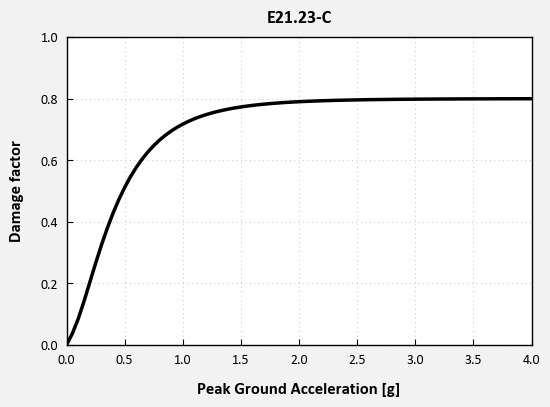

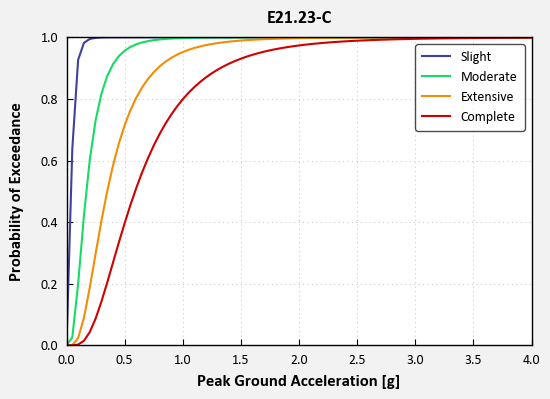

In [40]:
meta = get_curve_metadata(ID_number, network)
generate_plots(ID_number)

## 2nd Example: Energy - Windstorms

In [41]:
network="Energy"

Select the filtering criteria below to display all available ID numbers that match the chosen sector, hazard, and intensity measure.

In [42]:
styled, raw = filter_curves(
    network=network,
    hazard_type="W",
    intensity_metric="3-sec peak gust wind speed at 10 m height",
    cost_feature="Yes",
    geographical_application="Mexico"
)

display(styled)

,ID number,Infrastructure description,Additional characteristics,Characteristics of curve,Fragility and/or vulnerability,Damage states (in case of fragility),Reference
34,W1.1,Wind turbines,"1-MW capacity, 40-m hub height; fixed in the base; blades in feathered position minimizing the drag force",RC,F + V,"3 - 'Residual displacement', 'Yielding of tower', 'Collapse'",Jaimes et al. (2019)
35,W1.2,Wind turbines,"2.5-MW capacity, 80-m hub height; fixed in the base; blades in feathered position minimizing the drag force",RC,F + V,"3 - 'Residual displacement', 'Yielding of tower', 'Collapse'",Jaimes et al. (2019)
36,W1.3,Wind turbines,"3.3-MW capacity, 100-m hub height; fixed in the base; blades in feathered position minimizing the drag force",RC,F + V,"3 - 'Residual displacement', 'Yielding of tower', 'Collapse'",Jaimes et al. (2019)


Choose the appropriate ID_number from the table above to generate the corresponding vulnerability or/and fragility curves.

In [43]:
ID_number = "W1.1"


Curve info :
Hazard Type: W
Intensity Metric: 3-sec peak gust wind speed at 10 m height
Fragility/Vulnerability Type: F + V
Reference: Jaimes et al. (2019)

Intensity Measure Code: V10m
Units: [m/s]

Extracted Damage States: ['Residual displacement', 'Yielding of tower', 'Collapse']
Number of Damage States: 3


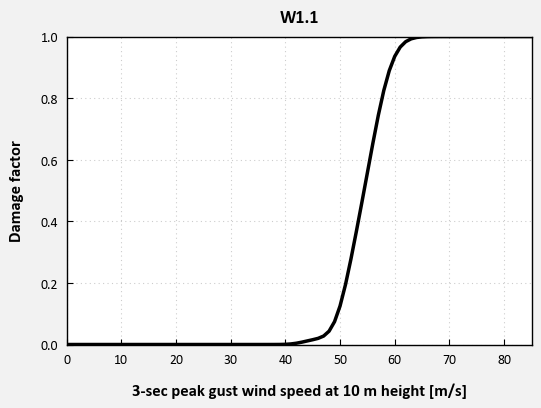

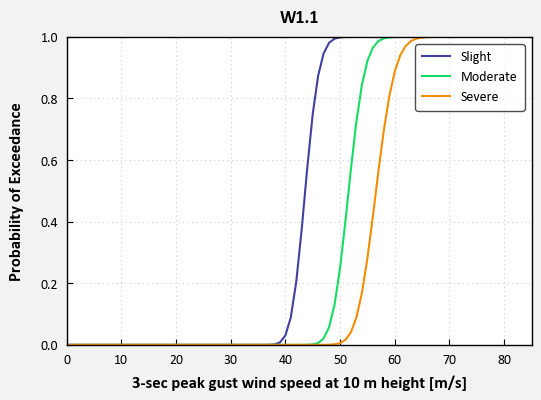

In [44]:
meta = get_curve_metadata(ID_number, network)
generate_plots(ID_number)